[Reference](https://medium.com/mlearning-ai/meta-ensemble-self-learning-model-with-optimization-9fa17d8764fa)

# Import & load the installed package meta-self-learner


In [1]:
!pip install meta-self-learner

In [15]:
# load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from tabulate import tabulate
from xgboost import XGBClassifier

# load built package functions
from msl.MetaLearning import *
from plot_metric.functions import MultiClassClassification
from msl.cf_matrix import make_confusion_matrix

#fixing random state
random_state=123

# Load your dataset


In [9]:
# Load dataset
X, Y = load_digits(n_class=4, return_X_y=True)

# Splitting data in training, validation & test set

In [10]:
### Once the data is generated it is splitted into:
    # training set: (X_train, y_train)
    # validation set: (X_valid, y_valid)
    # test set: (X_test, y_test)

## Spliting data into train and test sets.
X, X_test, y, y_test = train_test_split(X, Y, test_size=0.2, 
                                        random_state=123)
    
## Spliting train data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, 
                                                      random_state=1)

In [13]:
ll_sc, ll_ensemble1, ll_ensemble2, ll_ensemble1_cc, ll_ensemble2_cc, ll_ensemble3, ll_lr, ll_gb = [[] for i in range(8)]

# Set class configuration of the meta self ensembler

In [11]:
NUM_CLASS = MetaEnsemble.set_config(NUM_CLASS=4)

NUM_CLASS = 4


# Building the meta-self-learner architecture layer-by-layer in the pipeline

In [16]:
#Defining the classifiers
clfs = {'LR'  : LogisticRegression(random_state=random_state), 
        'SVM' : SVC(probability=True, random_state=random_state), 
        'RF'  : RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                       random_state=random_state), 
       'GBM' : GradientBoostingClassifier(n_estimators=50, 
                                          random_state=random_state), 
        'ETC' : ExtraTreesClassifier(n_estimators=100, n_jobs=-1, 
                                     random_state=random_state),
        'KNN' : KNeighborsClassifier(n_neighbors=30)}
    
#predictions on the validation and test sets
p_valid = []
p_test = []

########################### LAYER 1 ##########################
'''
First layer (individual classifiers)
All classifiers are applied twice:
Training on (X_train, y_train) and predicting on (X_valid)
Training on (X, y) and predicting on (X_test)
We can add / remove classifiers or change parameter values to see the effect on final results.
'''
print('Performance of individual classifiers (1st layer) on X_test')   
print('------------------------------------------------------------')

for lg, clf in clfs.items():
    #First run. Training on (X_train, y_train) and predicting on X_valid.
    clf.fit(X_train, y_train.ravel())
    yv = clf.predict_proba(X_valid)
    p_valid.append(yv)

    # second run. Training on (X, y) and predicting on X_test.
    clf.fit(X, y.ravel())
    yt= clf.predict_proba(X_test)
    p_test.append(yt)

    # print the performance for each classifier
    print('{:10s} {:2s} {:1.7f}'. format('%s:' %(lg), 'logloss =>', log_loss(y_test, yt)))
    #Saving the logloss score
    ll_sc.append(log_loss(y_test, yt)) #Saving the logloss score
print('')

Performance of individual classifiers (1st layer) on X_test
------------------------------------------------------------
LR:        logloss => 0.0461206


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


SVM:       logloss => 0.0326186
RF:        logloss => 0.1511517
GBM:       logloss => 0.0568729
ETC:       logloss => 0.1294562
KNN:       logloss => 0.0461759



In [17]:
########################### LAYER 2 ##########################
'''
(optimization based ensembles)
Predictions on X_valid are used as training set (XV) and predictions on X_test are used as test set (XT). 
Ensemble1, Ensemble2 and their calibrated versions are applied.
'''
print('Performance of optimization based meta self-learners (2nd layer) on X_test')
print('------------------------------------------------------------')
#Creating the data for the 2nd layer.

XV = np.hstack(p_valid)
XT = np.hstack(p_test)

# Ensemble1

en1 = MetaEnsemble.Ensemble_one(NUM_CLASS) # as we have 4 classes n_classes=4
en1.fit(XV, y_valid.ravel())
w_en1 = en1.w
y_en1 = en1.predict_proba(XT)
print('{:20s} {:2s} {:1.7f}'.format('Ensemble1:', 'logloss =>', log_loss(y_test, y_en1)))
ll_ensemble1.append(log_loss(y_test, y_en1)) #Saving the logloss score

#Calibrated version of Ensemble1

cc_en1 = CalibratedClassifierCV(en1, method='isotonic')
cc_en1.fit(XV,y_valid.ravel())
y_cc_en1 = cc_en1.predict_proba(XT)
print('{:20s} {:2s} {:1.7f}'.format('Calibrated_Ensemble1:', 'logloss =>', log_loss(y_test, y_cc_en1)))
ll_ensemble1_cc.append(log_loss(y_test, y_cc_en1)) #Saving the logloss score

# Ensemble2

en2 = MetaEnsemble.Ensemble_two(NUM_CLASS) # as we have 4 classes n_classes=4
en2.fit(XV,y_valid.ravel())
w_en2 = en2.w
y_en2 = en2.predict_proba(XT)
print('{:20s} {:2s} {:1.7f}'.format('Ensemble2:', 'logloss =>', log_loss(y_test, y_en2)))
ll_ensemble2.append(log_loss(y_test, y_en2)) #Saving the logloss score

#Calibrated version of Ensemble2

cc_en2 = CalibratedClassifierCV(en2, method='isotonic')
cc_en2.fit(XV,y_valid.ravel())
y_cc_en2 = cc_en2.predict_proba(XT)
print('{:20s} {:2s} {:1.7f}'.format('Calibrated_Ensemble2:', 'logloss =>', log_loss(y_test, y_cc_en2)))
ll_ensemble2_cc.append(log_loss(y_test, y_cc_en2)) #Saving the logloss score
print('')

Performance of optimization based meta self-learners (2nd layer) on X_test
------------------------------------------------------------
Ensemble1:           logloss => 0.0461206
Calibrated_Ensemble1: logloss => 0.0478476
Ensemble2:           logloss => 0.0461206
Calibrated_Ensemble2: logloss => 0.0478476



In [18]:
############# Third layer (weighted average) ######################################
# Simple weighted average of the previous 4 predictions.
print('Performance of agggregation of the self-learners (3rd layer) on X_test')
print('------------------------------------------------------------')
y_thirdlayer = (y_en1 * 4./9.) + (y_cc_en1 * 2./9.) + (y_en2 * 2./9.) + (y_cc_en2 * 1./9.)
print('{:20s} {:2s} {:1.7f}'.format('3rd_layer:', 'logloss =>', log_loss(y_test, y_thirdlayer)))
ll_ensemble3.append(log_loss(y_test, y_thirdlayer))

Performance of agggregation of the self-learners (3rd layer) on X_test
------------------------------------------------------------
3rd_layer:           logloss => 0.0465251


# Performance evaluation & creating graph plots for log loss metrics

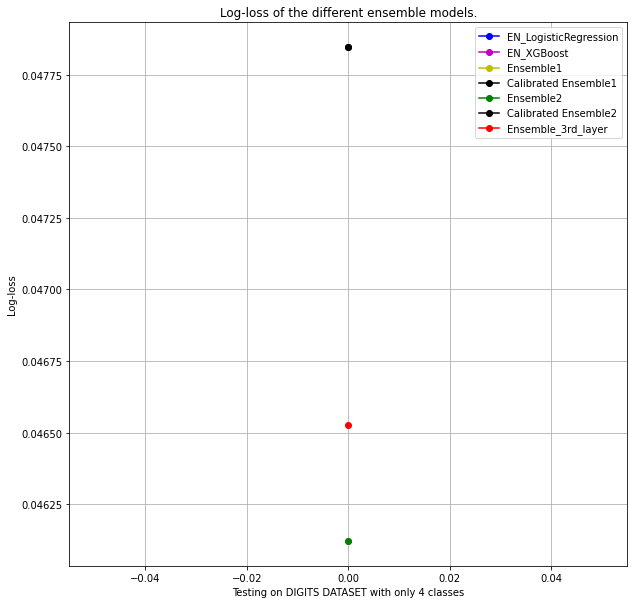

In [19]:
ll_ensemble1 = np.array(ll_ensemble1)
ll_ensemble2 = np.array(ll_ensemble2)
ll_ensemble3 = np.array(ll_ensemble3)
ll_ensemble1_cc = np.array(ll_ensemble1_cc)
ll_ensemble2_cc = np.array(ll_ensemble2_cc)
ll_lr = np.array(ll_lr)
ll_gb = np.array(ll_gb)

plt.figure(figsize=(10,10))

plt.title('Log-loss of the different ensemble models.')
plt.xlabel('Testing on DIGITS DATASET with only 4 classes')
plt.ylabel('Log-loss')
plt.plot(ll_lr, 'bo-', label='EN_LogisticRegression', )
plt.plot(ll_gb, 'mo-', label='EN_XGBoost')
plt.plot(ll_ensemble1, 'yo-', label='Ensemble1')
plt.plot(ll_ensemble1_cc, 'ko-', label='Calibrated Ensemble1')
plt.plot(ll_ensemble2, 'go-', label='Ensemble2')
plt.plot(ll_ensemble2_cc, 'ko-', label='Calibrated Ensemble2')
plt.plot(ll_ensemble3, 'ro-', label='Ensemble_3rd_layer')

plt.grid(True)
plt.legend(loc=1)
plt.show()

# Plot ROC, Confusion Matrix, and displaying classification report

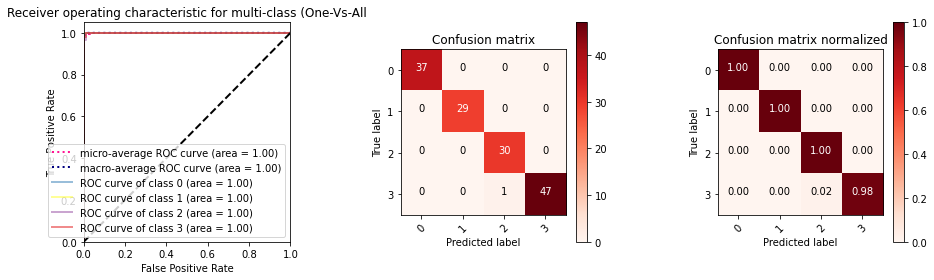

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        29
           2       0.97      1.00      0.98        30
           3       1.00      0.98      0.99        48

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



In [21]:
# Visualisation with PLOTS:
mc = MultiClassClassification(y_test, y_thirdlayer, labels=[0, 1, 2, 3])
plt.figure(figsize=(13,4))
plt.subplot(131)
mc.plot_roc()
plt.subplot(132)
mc.plot_confusion_matrix()
plt.subplot(133)
mc.plot_confusion_matrix(normalize=True)

# plt.savefig('figures/images/plot_multi_classification.png')
plt.show()

mc.print_report()